In [1]:
#imports
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
splat.initializeStandards()
import seaborn as sns
splat.initializeStandards(all=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%matplotlib inline


Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
 KVALS={'2MASS_KS': {\
            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
            'rms': np.zeros(65)+0.05}}

In [3]:
def get_colors(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = splat.filterMag(sp, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

In [4]:
#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.3) | (splat_db.J_2MASS_E > 0.3)  |
                (splat_db.SPEX_TYPE.apply(splat.typeToNum) <15))]

sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [5]:
#get y dwarfs
def get_shortname(n):
    return splat.designationToShortName(n).replace('J', 'WISE')
schn='/Users/caganze/research/wisps/data/schneider/*.txt'
schntb=pd.read_csv('/Users/caganze/research/wisps/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [6]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

In [7]:
#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

In [8]:
def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df

In [9]:
#tdwarfs.MEDIAN_SNR

In [10]:
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [11]:
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [12]:
def get_file(x):
    try:
        return splat.getSpectrum(filename=x)[0]
    except:
        return 

In [13]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: get_file(x))
sds_spectra=sds.DATA_FILE.apply(lambda x:  get_file(x))


#all_spectra=pd.read_pickle('/users/caganze/research/popsims/data/splat_spectra.pkl')
#sd_spectra=pd.read_pickle('/users/caganze/research/popsims/data/sd_spectra.pkl')

In [14]:
schntb['spectra']=[x[0] for x in  spectra_schn]

schntb['snr']=[x[1] for x in  spectra_schn]

schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

all_spectra=np.concatenate([templs,schntb.spectra.values ])

In [15]:
len(templs)

326

In [16]:
import pickle
output = open('/users/caganze/research/popsims/data/splat_spectra.pkl', 'wb')
pickle.dump(all_spectra, output)
output.close()

import pickle
output = open('/users/caganze/research/popsims/data/sd_spectra.pkl', 'wb')
pickle.dump(sds_spectra, output)
output.close()


In [17]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [18]:
spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
                     schntb.Spec.apply(make_spt_number).values,
                    ])

In [19]:
assert len(spts) == len(all_spectra)

In [20]:
sds_spts=sds.SPEX_TYPE.apply(make_spt_number).values

In [76]:
#this has already been simulated 
#fl_pairs= [['WFIRST_WFIJ', '2MASS J'],
#               ['WFIRST_WFIY', '2MASS J'],
#               ['WFIRST_WFIZ', '2MASS J'],
#               ['WFIRST_WFIH', '2MASS H'],
#               ['WFIRST_WFIF', '2MASS H'],
#               ['WFIRST_WFIR', 'PANSTARRS_R'],
#               ['EUCLID_J', '2MASS J'],
#               ['EUCLID_H', '2MASS H'],
#               ['EUCLID_Y','2MASS J'],
#               ['LSST_Y', '2MASS J'],
#               ['LSST_Z', '2MASS J'],
#               ['LSST_R', 'PANSTARRS_R'],
#           ['NIRCAM_F115W','2MASS J'],
#           ['NIRCAM_F140M', '2MASS H'],
#           ['NIRCAM_F150W', '2MASS H'],
#           ['NIRCAM_F200W', '2MASS H'],
#           ['WFC3_F110W', '2MASS J'],
#           ['WFC3_F140W', '2MASS J'],
#           ['WFC3_F160W', '2MASS H']]
#only add subdwarfs
#fl_pairs=[['NIRCAM_F115W','2MASS J'],
#          ['NIRCAM_F140M', '2MASS H'],
#           ['NIRCAM_F150W', '2MASS H'],
#           ['NIRCAM_F200W', '2MASS H']]

In [22]:
#remove nones
nones= np.array(all_spectra)==None
all_spectra=all_spectra[~nones]
spts=spts[~nones]
assert len(spts) == len(all_spectra)

In [23]:
def wfirst_colors(sp):
    sp.normalize()
    res={}
    for p in fl_pairs:
        res.update({p[0]+'and'+p[1]: \
                    get_colors(sp, p[0], p[1])})
    return res

In [49]:
zhang_subds=pd.read_pickle('/users/caganze/research/popsims/data/zhang_subdwarfs.pkl')

In [72]:
zhang_subds=zhang_subds.dropna()

In [73]:
import astropy.units as u
def make_zhang_spectra(row):
    return splat.Spectrum(wave=row.wave*u.micron, flux=row.flux, name=row['name'])

In [74]:
zhang_spectra=zhang_subds.apply(make_zhang_spectra, axis=1)
#zhang_subds.iloc[0]

In [86]:
#zhang_spectra.values

In [89]:
zhang_df=pd.DataFrame.from_records([wfirst_colors(x) for x in tqdm(zhang_spectra.values)])

100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


In [96]:
zhang_df['spt']=zhang_subds.spt.apply(make_spt_number)

In [100]:
#df
#df=pd.DataFrame.from_records([wfirst_colors(x) for x in tqdm(all_spectra)])
#df['spt']=spts

In [99]:
sd_df=pd.DataFrame.from_records([wfirst_colors(x) for x in tqdm(sds_spectra)])
sd_df['spt']=sds_spts

100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


In [106]:
len(sd_df), len(zhang_df)

(38, 90)

In [107]:
#add zhang to subdwargs
sd_df_total=sd_df.append(zhang_df)

In [108]:
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    #use median sigma
    #median_sigma= np.nanmedian(sigma_y)
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [102]:
#la base 


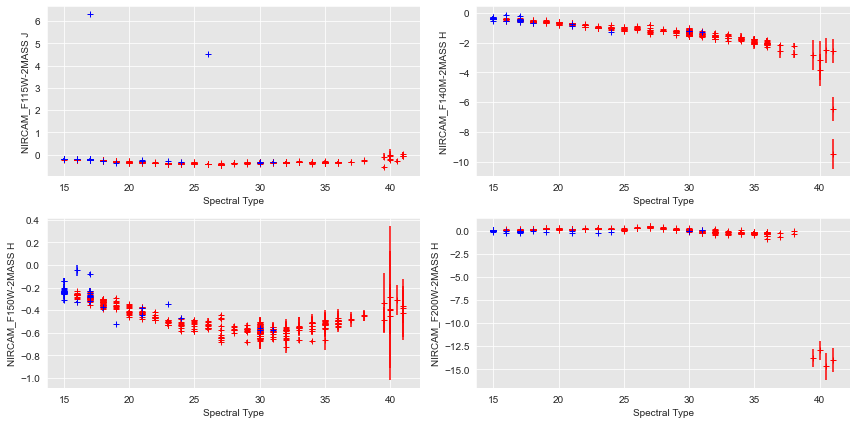

In [113]:
fig, ax=plt.subplots(2, 2, figsize=(12, 6))
for c, a in zip(sd_df_total.columns, np.concatenate(ax)):
    if c=='spt':
        pass
    else:
        #fit=None
        vals=np.vstack(df[c].apply(lambda x: np.array(x)).values)
        sd_vals=np.vstack(sd_df_total[c].apply(lambda x: np.array(x)).values)
        
    
        
       
      
        a.errorbar(spts, vals[:,0], fmt='+', 
                   yerr=vals[:,1], color='r')
        
        a.errorbar(sd_df_total.spt, sd_vals[:,0], fmt='+', 
                   yerr=sd_vals[:,1], color='b')
       
        
        #a.plot(np.arange(15, 43), fit(np.arange(15, 43)), c='k')
        a.set_ylabel(c.upper().replace('AND', '-'))
        a.set_xlabel('Spectral Type')
        plt.tight_layout()


In [30]:
#absolute magnitude relation
import splat.empirical as spe

kirkpa2019pol={'2MASS H':{'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                    'scatter':.67, 'range':[36, 44]}}
kirkpa2020pol={'2MASS H':{'pol':np.poly1d(np.flip([-6.918e01, 1.1863e+01,-5.4084e-1, 8.466e-03 ])), 
                    'scatter':.51, 'range':[36, 44]}}
best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]},
       
        'PANSTARRS_R': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,28], \
            'values': [15.37,16.76,17.74,18.14,18.37,18.74,19.02,19.61,20.60,20.74,21.21,22.88],\
            'rms': [0.43,0.50,0.51,0.37,0.31,0.28,0.29,0.39,0.56,0.37,0.78,0.5]},
        'PANSTARRS_I': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35], \
            'values': [13.25,14.18,15.00,15.62,16.00,16.41,16.73,17.40,18.35,18.71,19.27,20.09,20.38,20.09,20.22,21.10,21.97,22.69],\
            'rms': [0.34,0.39,0.48,0.39,0.26,0.25,0.26,0.34,0.38,0.33,0.65,0.36,0.79,0.5,1.14,0.5,0.5,0.5]},
        'PANSTARRS_Z': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [12.27,12.98,13.61,14.17,14.52,14.93,15.30,15.88,16.68,16.94,17.35,18.18,18.10,17.69,17.98,18.84,18.26,18.08,18.02,19.20,19.82,21.17,21.52,21.82],\
            'rms': [0.32,0.34,0.45,0.37,0.25,0.23,0.24,0.21,0.33,0.29,0.62,0.26,0.22,0.73,0.5,0.21,0.23,0.25,0.39,0.22,0.32,0.78,0.52,0.5]},
        'PANSTARRS_Y': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [11.76,12.31,12.81,13.23,13.58,13.97,14.33,14.89,15.66,15.87,16.27,17.13,17.04,16.57,16.77,17.45,16.75,16.50,16.32,17.43,18.06,19.34,19.75,20.37],\
            'rms': [0.30,0.31,0.43,0.36,0.23,0.21,0.24,0.29,0.32,0.28,0.61,0.25,0.21,0.72,0.5,0.16,0.13,0.22,0.38,0.18,0.32,0.81,0.59,0.5]}}

BEST={}
for k in best_dict.keys():
    BEST[k]=fit_with_nsigma_clipping(np.array(best_dict[k]['spt']), 
                                      np.array(best_dict[k]['values']), 
                                      np.array(best_dict[k]['rms'])
                                     , 6, sigma=5.)
from astropy.io import ascii
def make_mamajek_fit(spt):
    mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(splat.typeToNum).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return ((jval, 0.4), (hval, 0.4))

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        pol=kirkpa2019pol[filt]['pol']
        unc=kirkpa2019pol[filt]['scatter']
        return pol(spt-30), unc
    

def get_abs_mag(spt, flter):
    m, munc=(np.nan, np.nan)
    if flter=='2MASS J':
        corr=splat.photometry.vegaToAB('2MASS J')
        #m, munc= spe.typeToMag(spt, '2MASS J')
        ((m, munc), (h, hunc))=make_mamajek_fit(spt)
        m= m+corr
        
    if flter=='2MASS H':
        corr=splat.photometry.vegaToAB('2MASS H')
        if spt <36:
            
            #m=BEST['2MASS H'][1](spt)
            #munc= np.nanmedian(best_dict[k]['rms'])
            #m, munc=spe.typeToMag(spt, '2MASS H')
            ((j, junc), (m, munc))=make_mamajek_fit(spt)
            m= m+corr
        else:
            m, munc=absolute_mag_kirkpatrick(spt, '2MASS H')
            m= m+corr
           
            
    if flter=='PANSTARRS_R':
        corr=splat.photometry.vegaToAB('PANSTARRS_R')
        m=(BEST[k][1])(spt)+corr
        munc=np.nanmedian(best_dict[k]['rms'])
    return m, munc

In [31]:
#import popsims
#popsims.get_distance(get_abs_mag(25, '2MASS J')[0], 28.)

In [32]:
sp_grid=np.arange(15, 42)

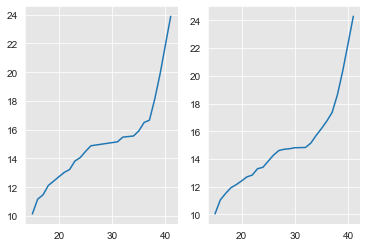

In [33]:
#la base
fig, ax=plt.subplots(ncols=2)
ax[0].plot(sp_grid, get_abs_mag(sp_grid, '2MASS J')[0])
ax[1].plot(sp_grid, np.array([get_abs_mag(x, '2MASS H')[0] for x in sp_grid]))
#there shouldn't be a bump in abs_mags

In [34]:
splat.photometry.vegaToAB('2MASS H')

1.3716878378948147

In [35]:
def get_abs_mags(row):
    res={}
    
    for p in fl_pairs:
        cl=p[0]+'and'+p[1]
        v, ve=get_abs_mag(row.spt, p[1])
        absm= row[cl][0]+v
        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)
        
    

In [116]:
abs_df=df.apply(get_abs_mags, axis=1)
sd_abs_df=sd_df_total.apply(get_abs_mags, axis=1)

In [118]:
#sd_abs_df

In [119]:
#remove y-dwarfs for jswt filters because they look horrid
abs_df.keys()

Index(['NIRCAM_F115W', 'NIRCAM_F140M', 'NIRCAM_F150W', 'NIRCAM_F200W'], dtype='object')

In [120]:
#FITS={}
FITS=pd.read_pickle('/users/caganze/research/popsims/data/polynomial_relations.pkl')

In [134]:
FITS['subdwarfs']={}

In [135]:
FITS['subdwarfs']

{}

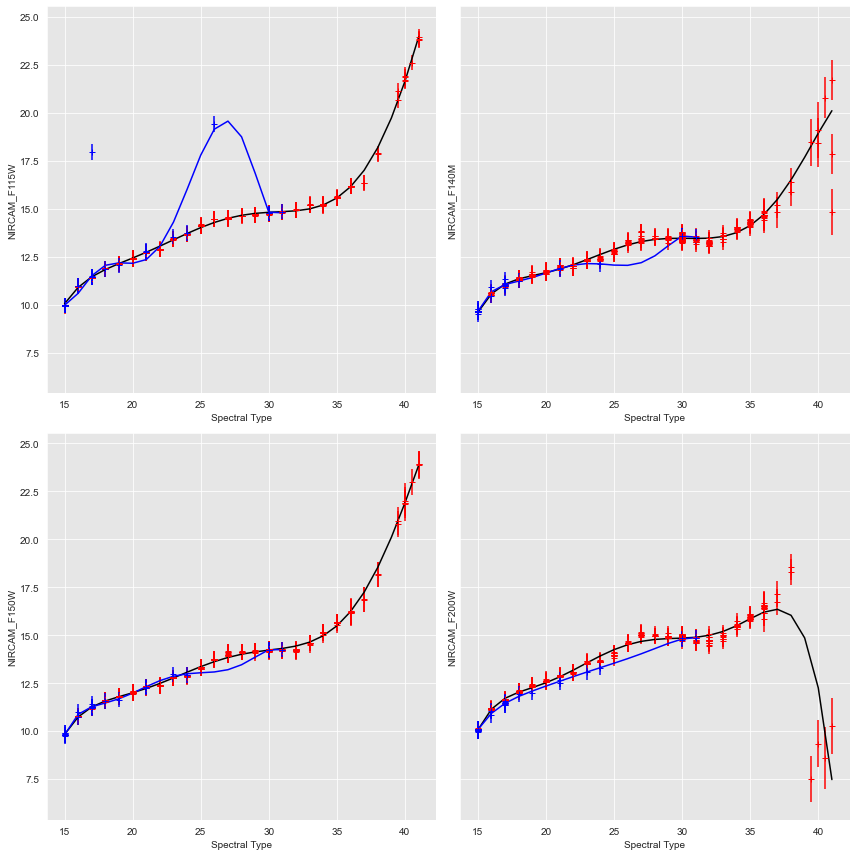

In [147]:
#

fig, ax=plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for c, a in zip(abs_df.columns, np.concatenate(ax)):
    if c=='spt':
        pass
    else:
        vals=np.vstack(abs_df[c].values)
        sd_vals=np.vstack(sd_abs_df[c].values)
        spts=df.spt.values
        sd_spts=sd_df_total.spt.values
        
        #masks
        mask= np.logical_or.reduce([np.isnan(spts), 
                                    np.isnan(vals[:,0]),
                                    np.isnan(vals[:,1])])

        m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                      vals[:,0][~mask], 
                                      vals[:,1][~mask], 6, sigma=3.)
        #same for subdwarfs
        
        sd_mask= np.logical_or.reduce([np.isnan(sd_spts), 
                                    np.isnan(sd_vals[:,0]),
                                    np.isnan(sd_vals[:,1])])

        sd_m, sd_fit= fit_with_nsigma_clipping(sd_spts[~sd_mask], 
                                      sd_vals[:,0][~sd_mask], 
                                      sd_vals[:,1][~sd_mask], 6, sigma=3.)
        #same for subdwarfs
        
        a.errorbar(spts, vals[:,0], fmt='+', 
                   yerr=vals[:,1], color='r')
        
        a.errorbar(sd_spts, sd_vals[:,0], fmt='+', 
                   yerr=sd_vals[:,1], color='b')
          
        #a.errorbar(spts[~mask][~m], vals[:,0][~mask][~m], fmt='+', 
        #           yerr=vals[:,1][~mask][~m], color='b')
        FITS['subdwarfs'].update({c: (sd_fit, np.nanmedian(sd_vals[:,1]))})
        a.plot(np.arange(15, 42), fit(np.arange(15, 42)), c='k')
        a.plot(np.arange(15, 32), sd_fit(np.arange(15, 32)), c='b')
        a.set_ylabel(c)
        a.set_xlabel('Spectral Type')
        plt.tight_layout()
        #a.set_xlim([15, 41])
        #a.set_ylim([8, 25])


In [137]:
#updating WISE
#wise_dict=splat.SPT_ABSMAG_RELATIONS['best2018']['filters']['WISE_W1']
#_, fit_2massk=fit_with_nsigma_clipping(np.array(KVALS['2MASS_KS']['spt']), 
#                                      np.array( KVALS['2MASS_KS']['values']), 
#                                      np.array( KVALS['2MASS_KS']['rms'])
#                                     , 6, sigma=5.)
#add wise relations

#_, fit_wise1=fit_with_nsigma_clipping(np.array(wise_dict['spt']), 
#                                      np.array( wise_dict['values']), 
#                                      np.array( wise_dict['rms'])
#                                     , 6, sigma=5.)
#            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
#            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
#            'rms': np.zeros(65)+0.05}})

In [138]:
def get_kirkpatrick_wise(spt):
    corr=splat.photometry.vegaToAB('WISE_W1')
    #use kirkpatrick relation if no dupuy
   
    if spt > 36:
        mdict=splat.SPT_ABSMAG_RELATIONS['kirkpatrick2019']['filters']['WISE_W1']
        pol=np.poly1d(mdict['coeff'])
        rms=mdict['fitunc']
        return np.random.normal(pol(spt-30)+corr, rms)
    else:
        return np.random.normal(fit_wise1(spt)+corr, np.nanmedian(wise_dict['rms']))
        

In [139]:
(0.39**2+0.5**2)**0.5

0.6341135544995076

In [140]:
#get_kirkpatrick_wise(30-10)

In [ ]:
spts_grids=np.linspace(17, 44, 1000)
w1s=np.array([get_kirkpatrick_wise(x) for x in spts_grids])

In [ ]:
_, fit_wise=fit_with_nsigma_clipping(np.array(spts_grids), 
                                      np.array(w1s), 
                                      np.ones(len(w1s))*0.63
                                     , 6, sigma=5.)
plt.plot(spts_grids, w1s)
plt.plot(spts_grids,fit_wise(spts_grids) )


In [141]:
FITS.keys()

dict_keys(['WFIRST_WFIJ', 'WFIRST_WFIY', 'WFIRST_WFIZ', 'WFIRST_WFIH', 'WFIRST_WFIF', 'WFIRST_WFIR', 'EUCLID_J', 'EUCLID_H', 'EUCLID_Y', 'LSST_Y', 'LSST_Z', 'LSST_R', 'NIRCAM_F115W', 'NIRCAM_F140M', 'NIRCAM_F150W', 'NIRCAM_F200W', 'WFC3_F110W', 'WFC3_F140W', 'WFC3_F160W', '2MASS_K', 'WISE_W1', 'subdwarfs'])

In [142]:
#vals=np.vstack(abs_df['WFC3_F160W'].values)
#spts=df.spt.values
#plt.plot(spts, vals[:,0], 'o')

In [ ]:
#FITS['2MASS_K']=(fit_2massk, np.nanmedian(np.array( KVALS['2MASS_KS']['rms'])))
#FITS['WISE_W1']=(fit_wise, 0.63)

In [143]:
import pickle
output = open('/users/caganze/research/popsims/data/polynomial_relations.pkl', 'wb')
pickle.dump(FITS, output)
output.close()

In [ ]:
#FITS